In [121]:
import glob
import os
from os import path
import pandas as pd
import numpy as np
import shutil
from pathlib import Path
import cosmicsense as cs

In [122]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [123]:
%matplotlib inline

In [124]:
sddir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/sd/calibrator"
trg = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/sd/calibrator/cal.txt"
columns = ["rec_id", "datetime", "press", "press1", "press4", "temp1", "relhum1", "volt", "counts1", "nsecs1", "counts2", "nsecs2"]
pattern = "*.cal"
tmpfile = "tmpfile"

In [125]:
try:
    os.remove(tmpfile)
except:
    pass

# SD
print("SD: ", end="")
searchdir = os.path.join(sddir)
sdfiles = [filename for filename in Path(searchdir).glob("**/"+pattern)]
print("found %d files" % len(sdfiles))

SD: found 14 files


In [126]:
for name in sdfiles:
    print(".", end="")
    fin = open(name, "r")
    body = fin.read()
    # replace comment character
    body = body.replace("//", "#")
    # replace zombie line endings
    body = body.replace(",\r\n", "\r\n")
    body = body.replace(",\n", "\n")
    # comment out these lines
    body = body.replace("CRS#1:", "#CRS#1")
    body = body.replace("CRS#2:", "#CRS#2")
    myfile = open(tmpfile, 'a')
    myfile.write(body)
    myfile.close()
print("")

# MERGE
df = pd.read_csv(tmpfile, sep=",", comment="#", header=None, error_bad_lines=False, warn_bad_lines=True)
df.columns = columns
df.datetime = pd.to_datetime(df.datetime, format="%Y/%m/%d %H:%M:%S")
df = df.set_index("datetime")
df.insert(loc=1, column="datetime", value=df.index)
df = df.sort_index()
df = df[df.index >= "2019-07-25"]
dupl = df.index.duplicated(keep='first')
if np.any(dupl):
    print("Contains %d duplicates" % len(np.where(dupl)[0]))
    df = df[~dupl]
df.to_csv(trg, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S")
print("")

..............
Contains 2639 duplicates



### Calibration

In [127]:
attrs = pd.read_csv("jfc1table.csv", sep=";")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs.loc[[9,10,11,12,13],"hasdata"] = True
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,sens_mq,sens_fendt,sensitivity,sens_comment,id
id,,,,,,,,,,,,,,,
1,UP,CRS 2000-B,11.064395,47.825464,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1300,2100,1.190,NaN,1.190,1 x calibrator,1
2,UP,CRS 1000,11.061651,47.826620,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,0.452,NaN,0.452,1 x calibrator,2
3,UP,CRS 1000,11.059494,47.831677,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,NaN,0.458,0.458,cross-cal with #4,3
4,UP,Lab-C,11.061457,47.823908,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6000,9500,4.544,4.515,4.530,2 x calibrator,4
5,KIT,CRS 1000-B,11.063310,47.828752,True,True,2019-05-29 12:20:00,2019-05-31 08:35:00,800,1500,NaN,0.670,0.670,1 x calibrator,5
6,KIT,CRS 1000-B,11.064491,47.822520,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,800,1500,NaN,NaN,0.670,type average,6
7,KIT,CRS 1000-B,11.059960,47.828184,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1000,1700,NaN,NaN,0.670,type average,7
8,KIT,CRS 2000-B,11.060487,47.832478,True,True,2019-06-04 16:00:00,2019-06-05 11:53:00,1300,2500,NaN,1.160,1.160,1 x calibrator,8
9,UFZ,Styx Neutronica,11.066562,47.828935,True,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,NaN,NaN,1.000,None,9


In [128]:
fpath = "/media/x/cosmicsense/data/fendt/crns/"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS_merge.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    if id==18:
        df = df["2019-05-09 00:00:00":]
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-09 09:59:00 to 2019-08-06 06:41:00
2: 2019-05-07 11:02:13 to 2019-08-06 08:46:30
3: 2019-05-07 08:37:25 to 2019-07-16 10:26:00
4: 2019-05-07 15:21:29 to 2019-07-16 13:19:00
5: 2019-05-03 08:53:04 to 2019-07-19 09:29:00
6: 2019-05-03 09:34:48 to 2019-07-19 07:05:00
7: 2019-05-13 14:54:00 to 2019-07-19 09:20:00
8: 2019-05-01 00:46:00 to 2019-07-22 11:46:00
9: 2019-06-12 19:00:03 to 2019-08-26 11:52:35
10: 2019-05-14 20:00:04 to 2019-07-17 18:18:38
11: 2019-06-03 11:16:48 to 2019-08-30 10:33:37
12: 2019-06-03 16:00:04 to 2019-07-02 07:03:47
13: 2019-05-15 02:24:11 to 2019-08-20 01:52:12
14: 2019-05-08 06:45:44 to 2019-07-23 06:18:00
15: 2019-06-05 16:01:54 to 2019-06-15 09:59:00
16: 2019-05-14 13:45:00 to 2019-07-16 16:31:00
17: 2019-05-15 14:14:46 to 2019-07-16 11:46:00
18: 2019-05-14 10:16:06 to 2019-07-17 08:24:00
19: 2019-05-14 12:45:49 to 2019-07-17 12:25:00
21: 2019-05-13 13:38:38 to 2019-07-16 04:17:00
22: 2019-05-13 15:24:44 to 2019-07-15 09:45:00
23: 2019-05-15 15:55:3

In [129]:
cal = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd/20/cal.txt", sep="\t")
cal.datetime = pd.to_datetime(cal.datetime)
cal = cal.set_index("datetime")
# Accounting for counts in both tubes
cal["cph1"] = (cal.counts1 + cal.counts2) / cs.conv.s_to_h(cal.nsecs1)

In [130]:
attrs["calstartadj"] = attrs.calstart
attrs["calendadj"] = attrs.calend
attrs.loc[22, "calstartadj"] = pd.Timestamp("2019-05-22 11:00:00")
attrs.loc[22, "calendadj"] = pd.Timestamp("2019-05-23 12:00:00")
attrs.loc[16, "calstartadj"] = pd.Timestamp("2019-05-23 12:45:00")
attrs.loc[4, "calstartadj"] = pd.Timestamp("2019-05-28 15:45:00")
attrs.loc[24, "calstartadj"] = pd.Timestamp("2019-06-26 17:00:00")
attrs.loc[18, "calstartadj"] = pd.Timestamp("2019-06-27 18:10:00")
attrs.loc[13, "calstartadj"] = pd.Timestamp("2019-07-03 09:20:00")
attrs.loc[15, "calstartadj"] = pd.Timestamp("2019-07-04 14:20:00")
attrs.loc[9, "calstartadj"] = pd.Timestamp("2019-07-09 11:20:00")
attrs.loc[17, "calstartadj"] = pd.Timestamp("2019-07-10 14:00:00")

In [131]:
cal["id"] = -9999
for id in attrs[attrs.hascal].id:
    cal.loc[attrs.loc[id,"calstartadj"]:attrs.loc[id,"calendadj"], "id"] = id

In [132]:
calavgcph = cal.groupby('id', as_index=False)['cph1'].mean()

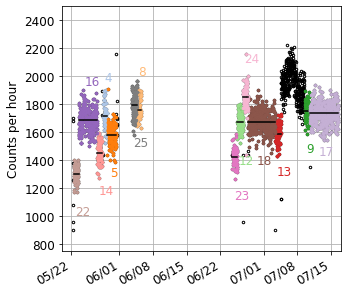

In [133]:
plt.rc('font', **{'size'   : 12})
colors = plt.cm.tab20(range(len(calavgcph)))
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
plt.plot(cal.index, cal.cph1, linewidth=0, marker=".", color="black", mfc="None", ms=5, label="unacc.")
plt.grid()
plt.xlim(dt.datetime(2019,5,20), dt.datetime(2019,7,17))
plt.ylim(750, 2500)
for i,id in enumerate(calavgcph.id):
    if not id==-9999:
        #start = attrs.loc[id,"calstartadj"]
        #end = attrs.loc[id,"calendadj"]
        #tmp = cal[start:end]
        plt.plot(cal.loc[cal.id==id].index, cal[cal.id==id].cph1, linewidth=0, marker=".", ms=5, color=colors[i], label=str(id))
        #plt.plot(tmp.loc[cal.id==id].index, tmp.loc[cal.id==id].cph1, linewidth=0, marker=".", ms=8, color=colors[i], label=str(id))
        plt.plot(attrs.loc[id,["calstartadj", "calendadj"]], np.repeat(calavgcph[calavgcph.id==id].cph1, 2), color="black", label="_tmp")
        startcal, endcal = attrs.loc[id,["calstartadj", "calendadj"]]
        plottime = startcal + 0.3*(endcal - startcal)
        if id in [16, 4, 8, 24, 15]:
            addval = 250
        else:
            addval = -300
        plt.text(plottime, calavgcph[calavgcph.id==id].cph1+addval, str(id), color=colors[i])
#plt.legend(ncol=6, columnspacing=0.001)
plt.ylabel("Counts per hour")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

fig.autofmt_xdate()

In [134]:
attrs.loc[9,"mincph"] =   800
attrs.loc[9,"maxcph"] =  3000
attrs.loc[10,"mincph"] = 1000
attrs.loc[10,"maxcph"] = 6500
attrs.loc[11,"mincph"] = 2000
attrs.loc[11,"maxcph"] = 4000
attrs.loc[12,"mincph"] = 2000
attrs.loc[12,"maxcph"] = 3500
attrs.loc[13,"mincph"] = 1000
attrs.loc[13,"maxcph"] = 3000

In [135]:
buffer = 0.075
#buffer = 0.15
mininterv = 600

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    # Today's specials
    if not key==1:
        #x[x > pars[key]["maxcph"]] = np.nan
        x[x > attrs.loc[key, "maxcph"]] = np.nan
    if key==1:
        x[:"2019-06-06 09:00:00"] = np.nan
    if key==2:
        # Weird behaviour
        x["2019-06-25 10:00:00":"2019-06-25 20:00:00"] = np.nan
        x["2019-06-26 10:00:00":"2019-06-26 20:00:00"] = np.nan
    #x[x < pars[key]["mincph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan        
    x[crns[key].nsecs1 < mininterv] = np.nan
    median24 = x.resample("24H", loffset=dt.timedelta(seconds=12*3600)).median()
    # Maxfilter
    max6 = x.resample("6H", loffset=dt.timedelta(seconds=3*3600)).max()
    median24max6 = max6.resample("24H", loffset=dt.timedelta(seconds=12*3600)).median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H", loffset=dt.timedelta(seconds=3*3600)).min()
    median24min6 = min6.resample("24H", loffset=dt.timedelta(seconds=12*3600)).median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    if not key==1:
        crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
        crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

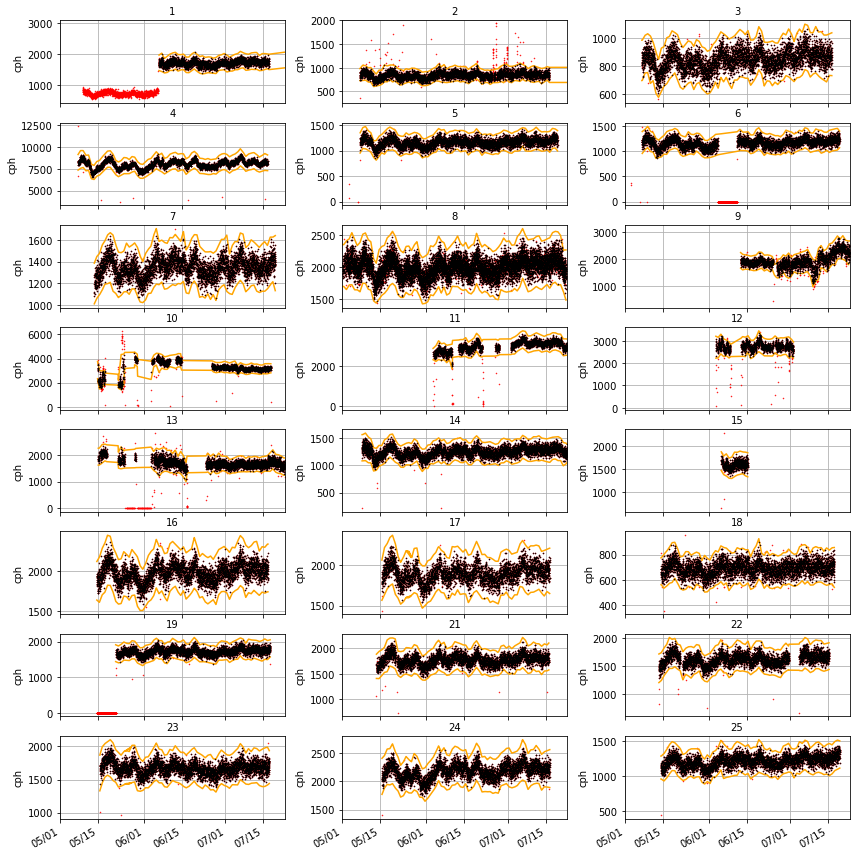

In [136]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(12,12), sharex=True)
ax = ax.ravel()

xlim = dt.datetime(2019,5,1), dt.datetime(2019,7,23)#max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key, fontsize=10)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    #ax[i].set_ylim(pars[key]["mincph"], pars[key]["maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.1)


In [137]:
calfacts = {"CRS 1000": np.array([]), "CRS 1000-B": np.array([]), "CRS 2000": np.array([]),
            "CRS 2000-B": np.array([]), "Lab-C": np.array([]), "Styx Neutronica": np.array([])}
attrs["calfact"] = np.nan
for id in attrs[attrs.hascal & attrs.hasdata].id:
    #if (calperiods[id] is not None) and (id in ids): 
    probeavg = np.nanmean(crns[id][str(attrs.loc[id,"calstart"]):str(attrs.loc[id,"calend"])].cph1_filtered)
    ratio = float(probeavg / calavgcph[calavgcph.id==id].cph1)
    attrs.loc[id,"calfact"] = ratio
    calfacts[attrs.loc[id, "type"]] = np.append(calfacts[attrs.loc[id, "type"]], round(ratio,2))
for key in calfacts.keys():
    print("%s: %s, mean factor: %.2f" % (key, calfacts[key], np.mean(calfacts[key])) )
for id in attrs[~attrs.hascal & attrs.hasdata].id:
    attrs.loc[id,"calfact"] = np.mean(calfacts[attrs.loc[id,"type"]])

CRS 1000: [0.41], mean factor: 0.41
CRS 1000-B: [0.67 0.67], mean factor: 0.67
CRS 2000: [0.87], mean factor: 0.87
CRS 2000-B: [1.16 1.15 1.12 1.17 1.13 1.14], mean factor: 1.14
Lab-C: [4.55], mean factor: 4.55
Styx Neutronica: [0.85 1.66 1.  ], mean factor: 1.17


## Marquardt

In [138]:
attrs = pd.read_csv("marquardt_table.csv", sep=",")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,calfactjfc1,id
id,,,,,,,,,,,,
1,UP,CRS 2000-B,12.958332,52.466406,True,True,2019-11-21 11:30:00,2019-12-05 12:35:00,1400,3000,1.143399,1
2,UP,CRS 1000,12.956236,52.466162,True,True,2019-10-15 11:40:00,2019-10-22 10:20:00,500,1100,0.436303,2
4,UP,Lab-C,12.957875,52.467125,True,True,2020-01-10 10:57:00,2020-01-13 11:56:00,5000,11000,4.554603,4
9,UFZ,Styx Neutronica,12.957530,52.465357,False,True,2019-12-11 09:10:00,2019-12-12 10:10:00,-9999,-9999,NaN,9
11,UFZ,Styx Neutronica,12.959199,52.466456,False,True,2019-12-17 14:40:00,2019-12-19 10:38:00,-9999,-9999,NaN,11
12,UFZ,Styx Neutronica,12.958328,52.467479,False,False,2020-01-13 11:56:00,2020-01-13 11:56:00,-9999,-9999,NaN,12
13,UFZ,Styx Neutronica,12.959222,52.465763,False,True,2020-01-09 09:36:00,2020-01-10 10:32:00,-9999,-9999,NaN,13
21,GFZ,CRS 2000-B,12.957486,52.465838,True,True,2019-12-05 12:35:00,2019-12-11 09:10:00,1400,3000,1.143399,21
22,GFZ,CRS 2000-B,12.958571,52.465570,True,True,2019-11-07 14:10:00,2019-11-21 11:30:00,1400,3000,1.168573,22


In [139]:
# nasty time shift
infile_on = pd.to_datetime("2019-09-15 08:54:04") # UTC
switch_on = pd.to_datetime("2019-09-19 10:00:00") # UTC
infile_off= pd.to_datetime("2019-10-05 13:33:00")# UTC
switch_off= pd.to_datetime("2019-10-09 14:44:00") # UTC
print(infile_on - switch_on, infile_off - switch_off)
time_shift_28 = infile_on - dt.timedelta(seconds=60*20) - switch_on
print(time_shift_28)

-5 days +22:54:04 -5 days +22:49:00
-5 days +22:34:04


In [140]:
fpath = "/media/x/cosmicsense/data/marquardt/crns/"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==28:
        df = df[:"2030-01-01"]
        # fix that nasty time shift
        index2 = df.index.to_pydatetime()
        changeix = (index2 >= infile_on) & (index2 <= infile_off)
        index2[changeix] = index2[changeix] - time_shift_28
        df = df.set_index(index2)
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-07-25 10:39:58 to 2020-01-15 10:30:00
2: 2019-07-31 12:37:38 to 2020-01-15 10:49:00
4: 2019-08-06 13:25:33 to 2020-01-15 10:43:00
21: 2019-07-25 00:17:00 to 2020-01-15 14:01:00
22: 2019-07-25 09:05:48 to 2020-01-15 10:57:00
26: 2019-08-23 10:20:31 to 2020-01-15 14:37:00
27: 2019-08-30 08:53:19 to 2020-01-15 13:54:00
28: 2019-09-12 09:55:02 to 2020-01-15 11:12:00


In [141]:
crns[27]

,rec_id,press1,temp1,relhum1,volt,counts1,nsecs1,counts3,nsecs3,counts2,nsecs2,cph1,cph2
datetime,,,,,,,,,,,,,
2019-08-30 08:53:19,1,1020.3,29.6,53.3,13.593,6,27,NaN,NaN,33,35,800.000000,3394.285714
2019-08-30 09:12:00,2,1020.4,29.8,50.1,13.394,247,1120,NaN,NaN,1083,1120,793.928571,3481.071429
2019-08-30 09:32:00,3,1020.4,29.9,37.5,13.706,268,1200,NaN,NaN,1092,1200,804.000000,3276.000000
2019-08-30 09:52:00,4,1020.4,30.2,34.8,13.713,244,1199,NaN,NaN,1151,1200,732.610509,3453.000000
2019-08-30 10:12:00,5,1020.2,30.7,32.7,13.671,280,1200,NaN,NaN,1116,1200,840.000000,3348.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-15 12:34:00,2087,1011.6,17.3,59.4,12.618,275,1200,193.0,1200.0,1098,1200,825.000000,3294.000000
2020-01-15 12:54:00,2088,1011.3,17.3,59.1,12.795,242,1200,174.0,1200.0,1056,1200,726.000000,3168.000000
2020-01-15 13:14:00,2089,1011.6,17.1,59.3,12.727,243,1200,177.0,1200.0,1057,1200,729.000000,3171.000000


In [142]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)

2019-07-25 00:17:00 - 2020-01-15 14:37:00


In [143]:
ratiolabc1000_26 = crns[26].cph2.mean() / crns[26].cph1.mean()
ratiolabc1000_27 = crns[27].cph2[np.isfinite(crns[27].cph2)].mean() / crns[27].cph1.mean()
print(ratiolabc1000_26, ratiolabc1000_27)

4.559638349096917 4.535512585244599


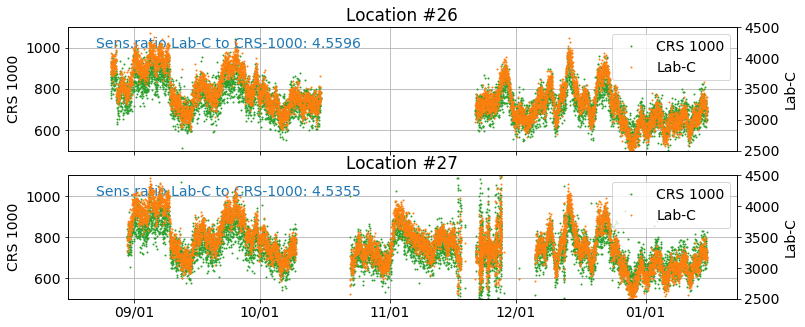

In [144]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,5), sharex=True, sharey=True)
ax = ax.ravel()

plt.sca(ax[0])
pl1000 = plt.plot(crns[26].index, crns[26].cph1, linestyle="None", marker=".", ms=2, color="tab:green", label="CRS 1000")
plt.ylabel("CRS 1000")
plt.ylim(500, 1100)
plt.title("Location #26")
plt.grid()
plt.text(dt.datetime(2019,8,23), 1000, "Sens.ratio Lab-C to CRS-1000: %.4f" % ratiolabc1000_26, color="tab:blue")

ax2 = ax[0].twinx()
plt.sca(ax2)
pllabc = plt.plot(crns[26].index, crns[26].cph2, linestyle="None", marker=".", ms=2, color="tab:orange", label="Lab-C")
plt.ylabel("Lab-C")
plt.ylim(2500, 4500)
lns = pl1000+pllabc
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plt.sca(ax[1])
pl1000 = plt.plot(crns[27].index, crns[27].cph1, linestyle="None", marker=".", ms=2, color="tab:green", label="CRS 1000")
plt.ylabel("CRS 1000")
#plt.ylim(500, 1000)
plt.title("Location #27")
plt.grid()
plt.text(dt.datetime(2019,8,23), 1000, "Sens.ratio Lab-C to CRS-1000: %.4f" % ratiolabc1000_27, color="tab:blue")

ax2 = ax[1].twinx()
plt.sca(ax2)
pllabc = plt.plot(crns[27].index, crns[27].cph2, linestyle="None", marker=".", ms=2, color="tab:orange", label="Lab-C")
plt.ylabel("Lab-C")
plt.ylim(2500, 4500)
lns = pl1000+pllabc
labs = [l.get_label() for l in lns]
_ = plt.legend(lns, labs)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [145]:
crns[26].cph1 = (crns[26].counts2 / ratiolabc1000_26 + crns[26].counts1) / 2. / cs.conv.s_to_h(crns[26].nsecs1)
crns[27].cph1 = (crns[27].counts2 / ratiolabc1000_27 + crns[27].counts1) / 2. / cs.conv.s_to_h(crns[27].nsecs1)

In [146]:
buffer = 0.1
mininterv = 600

# Adjust min/max rates for #26 and #27

attrs.loc[26, "mincph"] = 400
attrs.loc[27, "mincph"] = 400
attrs.loc[26, "maxcph"] = 1100
attrs.loc[27, "maxcph"] = 1100

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    x[x > attrs.loc[key, "maxcph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan        
    x[crns[key].nsecs1 < mininterv] = np.nan
    median24 = x.resample("24H").median()
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
    crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

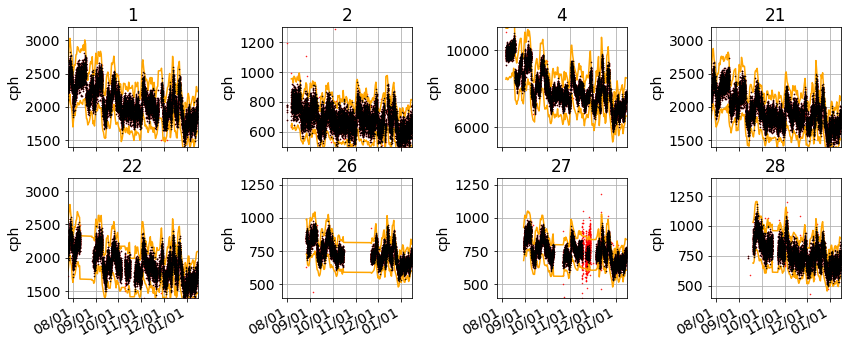

In [147]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,5), sharex=True)
ax = ax.ravel()

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    ax[i].set_ylim(attrs.loc[key,"mincph"], attrs.loc[key, "maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.2)

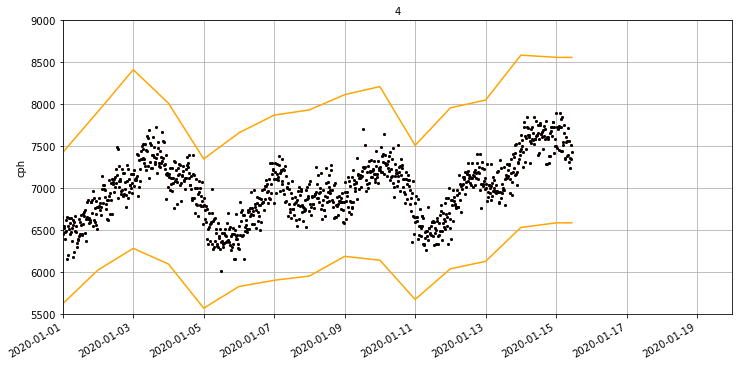

In [148]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(figsize=(12,6))

xlim = dt.datetime(2020,1,1), dt.datetime(2020,1,20)#max_dtime
key = 4
ax.plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=3, color="red")
ax.plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
ax.plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
ax.plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=4, color="black")
ax.set_title(key, fontsize=10)
ax.set_xlabel("")
ax.set_ylabel("cph")
ax.set_xlim(xlim)
ax.set_ylim(5500, 9000)
ax.grid()

fig.autofmt_xdate()  

In [149]:
cal = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/sd/calibrator/cal.txt", sep="\t")
cal.datetime = pd.to_datetime(cal.datetime)
cal = cal.set_index("datetime")
# Accounting for counts in both tubes
cal["cph1"] = (cal.counts1 + cal.counts2) / cs.conv.s_to_h(cal.nsecs1)

In [150]:
cal = cal.resample("20T").mean()
cal[cal.cph1 > 2170].cph1 = np.nan

In [151]:
attrs["calstartadj"] = attrs.calstart
attrs["calendadj"] = attrs.calend
attrs.loc[2, "calendadj"] = pd.Timestamp("2019-10-17 17:15:00")
attrs.loc[26, "calendadj"] = pd.Timestamp("2019-10-24 14:00:00")
attrs.loc[28, "calendadj"] = pd.Timestamp("2019-11-06 14:30:00")
attrs.loc[22, "calendadj"] = pd.Timestamp("2019-11-09 14:30:00")
attrs.loc[1, "calendadj"] = pd.Timestamp("2019-11-23 09:45:00")
attrs.loc[21, "calstartadj"] = pd.Timestamp("2019-12-05 12:50:00")
attrs.loc[21, "calendadj"] = pd.Timestamp("2019-12-07 08:30:00")
attrs.loc[9, "calendadj"] = pd.Timestamp("2019-12-12 09:45:00")
attrs.loc[27, "calstartadj"] = pd.Timestamp("2019-12-12 12:00:00")
attrs.loc[27, "calendadj"] = pd.Timestamp("2019-12-14 08:00:00")
attrs.loc[13, "calstartadj"] = pd.Timestamp("2020-01-09 09:40:00")
attrs.loc[13, "calendadj"] = pd.Timestamp("2020-01-10 10:10:00")
attrs.loc[4, "calstartadj"] = pd.Timestamp("2020-01-10 12:00:00")
attrs.loc[4, "calendadj"] = pd.Timestamp("2020-01-12 08:30:00")
# attrs.loc[9, "calstartadj"] = pd.Timestamp("2019-07-09 11:20:00")
# attrs.loc[17, "calstartadj"] = pd.Timestamp("2019-07-10 14:00:00")

In [152]:
cal["id"] = -9999
for id in attrs[attrs.hascal].id:
    print(id, attrs.loc[id,"calstartadj"], attrs.loc[id,"calendadj"])
    cal.loc[attrs.loc[id,"calstartadj"]:attrs.loc[id,"calendadj"], "id"] = id

1 2019-11-21 11:30:00 2019-11-23 09:45:00
2 2019-10-15 11:40:00 2019-10-17 17:15:00
4 2020-01-10 12:00:00 2020-01-12 08:30:00
9 2019-12-11 09:10:00 2019-12-12 09:45:00
11 2019-12-17 14:40:00 2019-12-19 10:38:00
13 2020-01-09 09:40:00 2020-01-10 10:10:00
21 2019-12-05 12:50:00 2019-12-07 08:30:00
22 2019-11-07 14:10:00 2019-11-09 14:30:00
26 2019-10-22 10:50:00 2019-10-24 14:00:00
27 2019-12-12 12:00:00 2019-12-14 08:00:00
28 2019-11-04 13:06:00 2019-11-06 14:30:00


In [153]:
calavgcph = cal.groupby('id', as_index=False)['cph1'].mean()

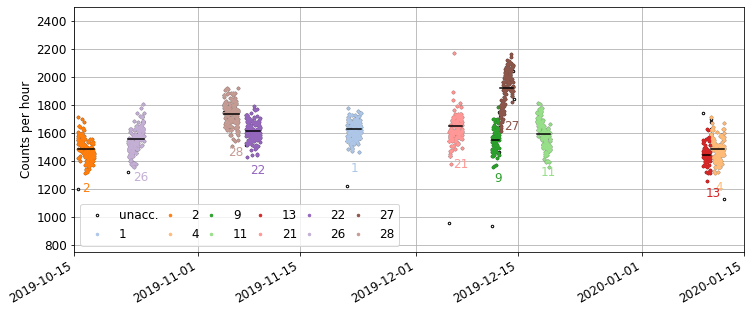

In [154]:
plt.rc('font', **{'size'   : 12})
colors = plt.cm.tab20(range(len(calavgcph)))
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
plt.plot(cal.index, cal.cph1, linewidth=0, marker=".", color="black", mfc="None", ms=5, label="unacc.")
plt.grid()
plt.xlim(dt.datetime(2019,10,15), dt.datetime(2020,1,15))
plt.ylim(750, 2500)
for i,id in enumerate(calavgcph.id):
    if not id==-9999:
        #start = attrs.loc[id,"calstartadj"]
        #end = attrs.loc[id,"calendadj"]
        #tmp = cal[start:end]
        plt.plot(cal.loc[cal.id==id].index, cal[cal.id==id].cph1, linewidth=0, marker=".", ms=5, color=colors[i], label=str(id))
        #plt.plot(tmp.loc[cal.id==id].index, tmp.loc[cal.id==id].cph1, linewidth=0, marker=".", ms=8, color=colors[i], label=str(id))
        plt.plot(attrs.loc[id,["calstartadj", "calendadj"]], np.repeat(calavgcph[calavgcph.id==id].cph1, 2), color="black", label="_tmp")
        startcal, endcal = attrs.loc[id,["calstartadj", "calendadj"]]
        plottime = startcal + 0.3*(endcal - startcal)
        if id in [16, 8, 24, 15]:
            addval = 250
        else:
            addval = -300
        plt.text(plottime, calavgcph[calavgcph.id==id].cph1+addval, str(id), color=colors[i])
plt.legend(ncol=6, columnspacing=0.001)
plt.ylabel("Counts per hour")
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

fig.autofmt_xdate()

In [155]:
calfacts = {"CRS 1000": np.array([]), "CRS 1000/Lab-C": np.array([]), "CRS 1000-B": np.array([]), "CRS 2000": np.array([]),
            "CRS 2000-B": np.array([]), "Lab-C": np.array([]), "Styx Neutronica": np.array([])}
attrs["calfact"] = np.nan
for id in attrs[attrs.hascal & attrs.hasdata].id:
    #if (calperiods[id] is not None) and (id in ids): 
    probeavg = np.nanmean(crns[id][str(attrs.loc[id,"calstartadj"]):str(attrs.loc[id,"calendadj"])].cph1)
    ratio = float(probeavg / calavgcph[calavgcph.id==id].cph1)
    attrs.loc[id,"calfact"] = ratio
    calfacts[attrs.loc[id, "type"]] = np.append(calfacts[attrs.loc[id, "type"]], round(ratio,3))
for key in calfacts.keys():
    print("%s: %s, mean factor: %.3f" % (key, calfacts[key], np.mean(calfacts[key])) )
for id in attrs[~attrs.hascal & attrs.hasdata].id:
    attrs.loc[id,"calfact"] = np.mean(calfacts[attrs.loc[id,"type"]])

CRS 1000: [0.452 0.459], mean factor: 0.456
CRS 1000/Lab-C: [  nan 0.435], mean factor: nan
CRS 1000-B: [], mean factor: nan
CRS 2000: [], mean factor: nan
CRS 2000-B: [1.19  1.126 1.161], mean factor: 1.159
Lab-C: [4.544], mean factor: 4.544
Styx Neutronica: [], mean factor: nan


/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [156]:
np.nanmean(crns[id][str(attrs.loc[4,"calstartadj"]):str(attrs.loc[4,"calendadj"])].cph1), \
np.nanmean(crns[id][str(attrs.loc[4,"calstartadj"]):str(attrs.loc[4,"calendadj"])].cph1_filtered)

(645.4458790847009, 645.4458790847009)

### Auswertung einzelner Röhren / Sonden

In [158]:
# JFC: CRNS 2, 4, 21, 22
ids = 1, 2, 4, 21, 22
for id in ids:
    probeavg = np.nanmean(crns[id][str(attrs.loc[id,"calstartadj"]):str(attrs.loc[id,"calendadj"])].cph1_filtered)
    ratio = float(probeavg / calavgcph[calavgcph.id==id].cph1)
    print("CRNS #%d: ratio=%.3f" % (id, ratio))

CRNS #1: ratio=1.190
CRNS #2: ratio=0.452
CRNS #4: ratio=4.544
CRNS #21: ratio=1.132
CRNS #22: ratio=1.161


In [36]:
# JFC: CRNS #3
id = 27
# This is the former #3 tube
tmp = crns[id].counts1 / crns[id].nsecs1
probeavg = np.nanmean(tmp[str(attrs.loc[id,"calstartadj"]):str(attrs.loc[id,"calendadj"])])
ratio = float(probeavg / calavgcph[calavgcph.id==id].cph1)
print("CRNS #%d (former #3): ratio=%.2f" % (id, ratio))

CRNS #27 (former #3): ratio=0.00


In [37]:
# CRNS 4
id = 3
marq4 = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote/4/4_CRNS.txt", sep="\t")
marq4.datetime = pd.to_datetime(marq4.datetime)
marq4 = marq4.set_index("datetime")
marq4["cph1"] = (marq4.counts1 + marq4.counts2) / cs.conv.s_to_h(marq4.nsecs1)
# CRNS 3
marq3 = pd.read_csv("/media/x/cosmicsense/data/marquardt/crns3_for_calibration_with_crns4/1908261215.003", sep=",", comment="#")
marq3.columns = ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", "counts1", "nsecs1", "counts2", "nsecs2"]
marq3.datetime = pd.to_datetime(marq3.datetime)
marq3 = marq3.set_index("datetime")
marq3["cph1"] = marq3.counts1 / cs.conv.s_to_h(marq3.nsecs1)
ratio = attrs.loc[4, "calfact"] * marq3["2019-08-26 13:00:00":"2019-08-30 09:00:00"].cph1.mean() / marq4["2019-08-26 13:00:00":"2019-08-30 09:00:00"].cph1.mean()
print("CRNS #%d: ratio=%.3f" % (id, ratio))

CRNS #3: ratio=0.464


In [211]:
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,calfactjfc1,id,calstartadj,calendadj,calfact
id,,,,,,,,,,,,,,,
1,UP,CRS 2000-B,12.958332,52.466406,True,True,2019-11-21 11:30:00,2019-12-05 12:35:00,1400,3000,1.143399,1,2019-11-21 11:30:00,2019-11-23 09:45:00,1.188566
2,UP,CRS 1000,12.956236,52.466162,True,True,2019-10-15 11:40:00,2019-10-22 10:20:00,500,1100,0.436303,2,2019-10-15 11:40:00,2019-10-17 17:15:00,0.446500
4,UP,Lab-C,12.957875,52.467125,True,True,2020-01-10 10:57:00,2020-01-13 11:56:00,6500,11000,4.554603,4,2020-01-10 12:00:00,2020-01-12 08:30:00,4.635203
9,UFZ,Styx Neutronica,12.957530,52.465357,False,True,2019-12-11 09:10:00,2019-12-12 10:10:00,-9999,-9999,NaN,9,2019-12-11 09:10:00,2019-12-12 09:45:00,NaN
11,UFZ,Styx Neutronica,12.959199,52.466456,False,True,2019-12-17 14:40:00,2019-12-19 10:38:00,-9999,-9999,NaN,11,2019-12-17 14:40:00,2019-12-19 10:38:00,NaN
12,UFZ,Styx Neutronica,12.958328,52.467479,False,False,2020-01-13 11:56:00,2020-01-13 11:56:00,-9999,-9999,NaN,12,2020-01-13 11:56:00,2020-01-13 11:56:00,NaN
13,UFZ,Styx Neutronica,12.959222,52.465763,False,True,2020-01-09 09:36:00,2020-01-10 10:32:00,-9999,-9999,NaN,13,2020-01-09 09:40:00,2020-01-10 10:10:00,NaN
21,GFZ,CRS 2000-B,12.957486,52.465838,True,True,2019-12-05 12:35:00,2019-12-11 09:10:00,1400,3000,1.143399,21,2019-12-05 12:50:00,2019-12-07 08:30:00,1.130523
22,GFZ,CRS 2000-B,12.958571,52.465570,True,True,2019-11-07 14:10:00,2019-11-21 11:30:00,1400,3000,1.168573,22,2019-11-07 14:10:00,2019-11-09 14:30:00,1.141690


In [212]:
tmp

datetime
2019-08-30 08:53:19    0.222222
2019-08-30 09:12:00    0.220536
2019-08-30 09:32:00    0.223333
2019-08-30 09:52:00    0.203503
2019-08-30 10:12:00    0.233333
                         ...   
2020-01-15 12:34:00    0.229167
2020-01-15 12:54:00    0.201667
2020-01-15 13:14:00    0.202500
2020-01-15 13:34:00    0.190833
2020-01-15 13:54:00    0.188333
Length: 8778, dtype: float64

In [213]:
crns[2][str(attrs.loc[2,"calstartadj"]):str(attrs.loc[2,"calstartadj"])].cph1

Series([], Name: cph1, dtype: float64)

In [214]:
attrs.loc[2,"calstartadj"]

Timestamp('2019-10-15 11:40:00')